In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [136]:
import sqlite3
con = sqlite3.connect("C:\\Users\\Owner\\pythone_mate\\Data_analysis\\py-restaurant-data-analysis\\db.sqlite3")
restaurant_order = pd.read_sql_query("SELECT * from restaurant_order", con)
restaurant_orderitem = pd.read_sql_query("SELECT * from restaurant_orderitem", con)
restaurant_product = pd.read_sql_query("SELECT * from restaurant_product", con)
data = restaurant_orderitem.merge(restaurant_order,left_on="order_id", right_on="id", how="inner")
data = data.merge(restaurant_product,left_on="product_id", right_on="id", how="inner").drop(["id_y", "order_id", "product_id", "id"], axis=1)
data = data.rename(columns={"id_x": "id"}).set_index("id")
data["datetime"] = pd.to_datetime(data['datetime'])

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

Text(0.5, 1.0, 'Top 10 most popular products in restaurant sold by Quantity')

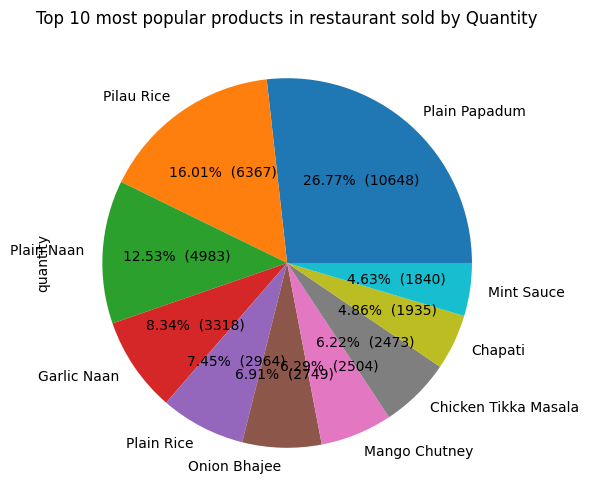

In [125]:
product_count = data.groupby("name").sum()
product_count = product_count.quantity.sort_values(ascending=False).head(10)
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
product_count.plot.pie(figsize=(6, 6), autopct=make_autopct(product_count))
plt.title("Top 10 most popular products in restaurant sold by Quantity")

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

Text(0.5, 1.0, 'Top 10 by Item Price')

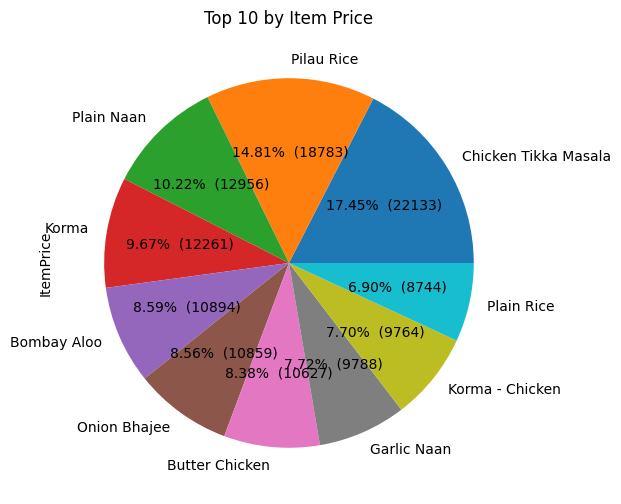

In [153]:
data["ItemPrice"] = data["quantity"] * data["price"]
product_count_item = data[["name", "ItemPrice"]].groupby("name").sum()
product_count_item = product_count_item.ItemPrice.sort_values(ascending=False).head(10)
product_count_item.plot.pie(figsize=(6, 6), autopct=make_autopct(product_count_item))
plt.title("Top 10 by Item Price")

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

Text(0.5, 1.0, 'Profit by Order Hour')

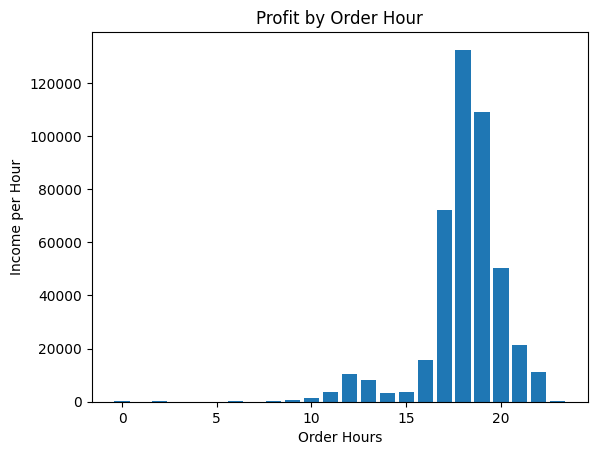

In [188]:
c = data.groupby(data["datetime"].dt.hour).sum("ItemPrice")
c = c["ItemPrice"]
plt.bar(c.index, c.values)
plt.xlabel("Order Hours")
plt.ylabel("Income per Hour")
plt.title("Profit by Order Hour")

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

Text(0.5, 1.0, 'Profit by Order Day of week')

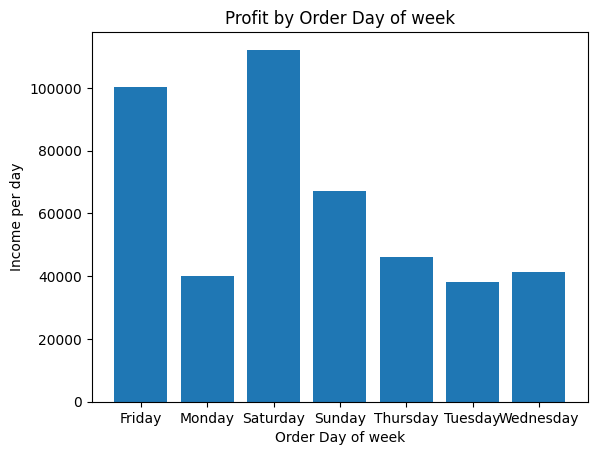

In [209]:
data["DayName"] = data["datetime"].dt.strftime("%A")
day_of_week = data.groupby(data["DayName"]).sum("ItemPrice")
day_of_week = day_of_week["ItemPrice"]

plt.bar(day_of_week.index, day_of_week.values)
plt.xlabel("Order Day of week")
plt.ylabel("Income per day")
plt.title("Profit by Order Day of week")